## Analiza dionica Zagrebačke burze
### Jupyter Notebook za analizu dionica korištenjem grafičkih tehničkih indikatora
Povijesni podaci o kretanju vrijednosti dionica kotiranih na Zagrebačkoj burzi dostupni su na web stranici: www.zse.hr
#### Primjer dionice:  ADPL-R-A

#### Creating Financial charts with historical stocks data from the Zagreb Stock Exchange (www.zse.hr).

In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import datetime as dt

In [3]:
import string
import urllib2
import bs4  # BeautifulSoup
import re  # regex

In [4]:
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter
from scipy import stats

/home/petar/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [5]:
sns.set(context='notebook', style='darkgrid', font_scale=1.2)

In [6]:
%matplotlib inline

In [7]:
# Povijesni podaci sa Zagrebačke burze (www.zse.hr)
# Historical stock data from the Zagreb Stock Exchange (www.zse.hr)
# Ticker: you need at least 200 days of trading data (2 years)
#stock_name = 'HT-R-A'
stock_name = 'ADPL-R-A'
quotes = pd.read_excel('zse_export_'+stock_name+'.xlsx')
quotes = quotes.set_index(pd.DatetimeIndex(quotes['Datum']))

In [8]:
# Cleaning data
del quotes['Datum']
del quotes['Vrsta prometa']
del quotes['Broj transakcija']
# Reverse order (timeline)
quotes = quotes.iloc[::-1]

In [9]:
# Add the latest data directly from the website (only last month of trading data)
# Web Scraping ZSE website for stock data
address = 'http://zse.hr/default.aspx?id=10006&dionica='+stock_name  # ADPL-R-A
page = urllib2.urlopen(address)
soup = bs4.BeautifulSoup(page, 'lxml')

In [10]:
# Extract table from web page
table = soup.find('table', class_='standard-table sorttable')
# Extract all rows from the table
rows = table.findAll('tr')
data = []; sdata = []
for row in rows[1:]:
    # Extract cells from each row
    cells = row.findAll('td')
    for elem in cells:
        # Extract text strings from cells
        data.append(elem.find(text=True))
clean_data = []
for s in data:
    # Remove non-printing characters from strings
    clean_data.append(re.sub('[^\040-\176]', '', s))

In [11]:
# Convert strings with commas to decimal numbers
def replace_convert(s):
    r = re.sub('[^0-9|,|-]', '', s)
    if r:
        r = float(r.replace(',', '.'))
    else:
        r = 0.
    return r

In [12]:
datum = []
prva = []
najvisa = []
najniza = []
zadnja = []
prosjecna = []
promjena = []
broj_tr = []
kolicina = []
promet = []
for i in range(0, len(clean_data), 11):
    datum.append(clean_data[i+1])
    prva.append(replace_convert(clean_data[i+2]))
    najvisa.append(replace_convert(clean_data[i+3]))
    najniza.append(replace_convert(clean_data[i+4]))
    zadnja.append(replace_convert(clean_data[i+5]))
    prosjecna.append(replace_convert(clean_data[i+6]))
    promjena.append(replace_convert(clean_data[i+7]))
    broj_tr.append(replace_convert(clean_data[i+8]))
    kolicina.append(replace_convert(clean_data[i+9]))
    promet.append(replace_convert(clean_data[i+10]))

In [13]:
column_names = ['Prva', 'Zadnja', u'Najviša', u'Najniža', u'Prosječna', 
                'Promjena', u'Količina', 'Promet']

In [14]:
podaci = pd.DataFrame(data={'Prva':prva, u'Najviša':najvisa, u'Najniža':najniza,
                            'Zadnja':zadnja, u'Prosječna':prosjecna, 'Promjena':promjena, 
                            u'Količina':kolicina, 'Promet':promet},
                      index=pd.to_datetime(datum, dayfirst=True), columns=column_names)

In [15]:
podaci = podaci.iloc[::-1]  # reverse order

In [16]:
# Adding new rows to the existing DataFrame
data_all = pd.concat([quotes, podaci])
# Remove duplicate dates
data_all = data_all.drop_duplicates(keep='last')
quotes = data_all.copy()
quotes.tail()

,Prva,Zadnja,Najviša,Najniža,Prosječna,Promjena,Količina,Promet
2017-03-28,157.00,156.54,159.00,156.54,157.13,-0.92,2623.0,412164.22
2017-03-29,156.00,155.00,158.00,151.36,154.36,-0.98,2531.0,390675.62
2017-03-30,154.99,154.00,155.00,147.00,151.02,-0.65,9949.0,1502503.83
2017-03-31,154.00,155.00,160.00,152.07,156.89,0.65,5124.0,803885.64
2017-04-03,157.00,160.00,160.81,156.00,159.42,3.23,8103.0,1291757.41


In [17]:
# Time window for the analysis (should be consistent with the provided data)
date_start = dt.date(2016, 9, 1)
#date_end = dt.date(2017, 3, 31)
# If last day use this
dateend = quotes.tail(1).index
date_end = dateend.to_pydatetime()[0]

In [18]:
# Simple log returns (%) of Close price
quotes['log_returns'] = np.log(quotes['Zadnja']).diff()*100

In [ ]:
# Prva      = Open
# Zadnja    = Close
# Najviša   = High
# Najniža   = Low
# Promjena  = Pct.Change
# Količina  = Volume
# Prosječna = Average

In [ ]:
# WARNING: We can "forward fill" missing days (weekend and non-trading days)
#          but this will create more (redundant) data for subsequent figures
#quotes = quotes.resample('D').mean()
#quotes = quotes.ffill()
#quotes.head(10)

In [ ]:
# NOTICE: We can resample data to form weekly (or monthly) values
#quotes_week = quotes.resample('W').mean()   # Weekly means
#quotes_month = quotes.resample('M').mean()  # Monthly means

In [19]:
# Simple Moving Averages
#http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:moving_averages
sma20 = quotes['Zadnja'].rolling(window=20).mean()
sma50 = quotes['Zadnja'].rolling(window=50).mean()
sma200 = quotes['Zadnja'].rolling(window=200).mean()

In [20]:
# Disparity index
# The disparity index (or disparity ratio), compares, as a percentage, 
# the latest close price to a chosen moving average. SMA (20) is used.
disparity = ((sma20-quotes['Zadnja'])/sma20)*100.

In [21]:
# Exponential Moving Averages
ema20 = quotes['Zadnja'].ewm(span=20).mean()
ema50 = quotes['Zadnja'].ewm(span=50).mean()
ema200 = quotes['Zadnja'].ewm(span=200).mean()

In [22]:
# Bollinger bands
#http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:bollinger_bands
ma20 = quotes['Zadnja'].rolling(window=20).mean()
sd20 = quotes['Zadnja'].rolling(window=20).std()
lowr = ma20 - 2*sd20
uppr = ma20 + 2*sd20

In [23]:
# Bollinger BandWidth (20)
bb_width = ((uppr - lowr)/ma20)*100.
bb_width_ma200 = bb_width.rolling(window=200).mean()

In [24]:
# MACD indicator - MACD(12,26,9)
#http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:
#moving_average_convergence_divergence_macd
ema12 = quotes['Zadnja'].ewm(span=12).mean()
ema26 = quotes['Zadnja'].ewm(span=26).mean()
macd_line = ema12 - ema26
signal_line = macd_line.ewm(span=9).mean()
macd_hist = macd_line - signal_line

In [25]:
# Percentage Price Oscillator - PPO(12,26,9)
#http://stockcharts.com/school/doku.php?id=chart_school:
#technical_indicators:price_oscillators_ppo
ppo_line = ((ema12 - ema26)/ema26)*100.
ppo_signal_line = ppo_line.ewm(span=9).mean()
ppo_hist = ppo_line - ppo_signal_line

In [26]:
# Percentage Volume Oscillator - PVO(12,26,9)
# http://stockcharts.com/school/doku.php?id=chart_school:
#technical_indicators:percentage_volume_oscillator_pvo
vol_ema12 = quotes[u'Količina'].ewm(span=12).mean()
vol_ema26 = quotes[u'Količina'].ewm(span=26).mean()
pvo_line = ((vol_ema12 - vol_ema26)/vol_ema26)*100.
pvo_signal_line = pvo_line.ewm(span=9).mean()
pvo_hist = pvo_line - pvo_signal_line

In [27]:
# Stochastic Oscillator (20,5,5)
# http://stockcharts.com/school/doku.php?id=chart_school:
#technical_indicators:stochastic_oscillator_fast_slow_and_full
lowest_low = quotes[u'Najniža'].rolling(window=20).min()
highest_high = quotes[u'Najviša'].rolling(window=20).max()
osc_line = ((quotes['Zadnja'] - lowest_low)/(highest_high - lowest_low))*100.
osc_line = osc_line.rolling(window=5).mean()  # SMA(5)
osc_signal = osc_line.rolling(window=5).mean()  # SMA(5)

In [28]:
# Relative strength index (RSI)
# From: http://matplotlib.org/examples/pylab_examples/finance_work2.html
def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)
    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)
    return rsi

In [29]:
# Compute RSI (14 days)
# http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:relative_strength_index_rsi
rsi = relative_strength(quotes['Zadnja'])

In [30]:
# Candlesticks (data preparation)
tindex = quotes.index.values
ttime = []
for k in tindex:
    y, m, d = str(k).split('-')
    ttime.append(dt.date(int(y), int(m), int(d[:2])))
mtime = mdates.date2num(ttime)
ohlc = quotes[['Prva', u'Najviša', u'Najniža', 'Zadnja']].values
qdata = np.c_[mtime, ohlc]

In [31]:
# Simple log returns
returns = quotes['log_returns'].ix[date_start:date_end].dropna()

In [32]:
# Daily VaR and CVaR from historical time window at 95% confidence
VaR = stats.scoreatpercentile(returns.values, 5)
ind = returns.values < VaR
CVaR = np.mean(returns[ind])
print('VaR = {:.2f} %, CVaR = {:.2f} %'.format(VaR, CVaR))

VaR = -1.80 %, CVaR = -2.34 %


In [33]:
# Mean and standard deviation of the simple log returns
mu_logret = returns.mean()
sd_logret = returns.std()
print('Mean return: {:.2f} %'.format(mu_logret))
print('St.dev. return: {:.2f}'.format(sd_logret))

Mean return: 0.18 %
St.dev. return: 1.29


In [34]:
# Volume-by-Price indicator
# http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:volume_by_price
# Volume-by-Price calculations are based on the entire period displayed on the chart. 
# Volume-by-Price calculations do not extend beyond the historical data shown on the chart.
# This example is based on closing prices and the default parameter setting (12):
#    1. Find the high-low range for closing prices for the entire period.  
#    2. Divide this range by 12 to create 12 equal price zones.
#    3. Total the amount of volume traded within each price zone.  
promet = quotes['Promet'].ix[date_start:date_end]
prices = quotes['Zadnja'].ix[date_start:date_end]
_, zones = np.histogram(prices, bins=12)
vol_by_price = []
for i in range(len(zones)-1):
    vol_by_price.append(promet[(prices > zones[i]) & (prices <= zones[i+1])].sum())
vol_by_price = np.asarray(vol_by_price)*1e-6  # Milions (kn)

In [35]:
# Ichimoku Cloud plot
# http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:ichimoku_cloud
# Najviša = High; Najniža = Low; Zadnja = Close
# Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
high9 = quotes[u'Najviša'].rolling(window=9).max()
low9 = quotes[u'Najniža'].rolling(window=9).min()
conversion_line = (high9 + low9)/2.
# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
high26 = quotes[u'Najviša'].rolling(window=26).max()
low26 = quotes[u'Najniža'].rolling(window=26).min()
base_line = (high26 + low26)/2.
# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
# This value is plotted 26 periods in the future
leading_span_A = ((conversion_line + base_line)/2.).shift(26)
# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
# This value is plotted 26 periods in the future
high52 = quotes[u'Najviša'].rolling(window=52).max()
low52 = quotes[u'Najniža'].rolling(window=52).min()
leading_span_B = ((high52 + low52)/2.).shift(26)
# Chikou Span (Lagging Span): Close plotted 26 days in the past
lagging_span = quotes['Zadnja'].shift(-26)

In [36]:
# Round number to the nearest base
def myround(x, base=5):
    return int(base * round(float(x)/base))

## Plot Variant A

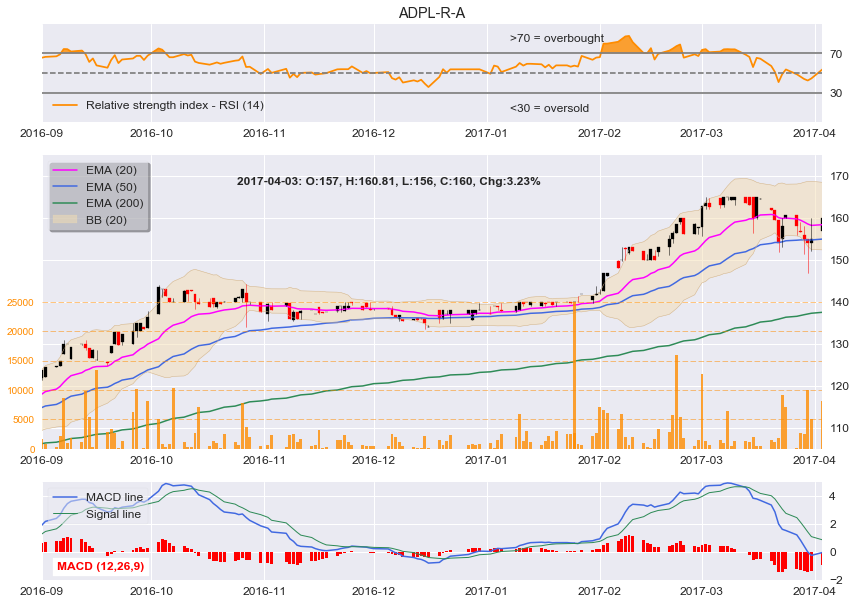

In [37]:
fig = plt.figure(figsize=(12,8.5))
gx = gs.GridSpec(nrows=3, ncols=1, height_ratios=[1,3,1])
axt = fig.add_subplot(gx[0])
ax0 = fig.add_subplot(gx[1], sharex=axt)
axr = ax0.twinx()
ax1 = fig.add_subplot(gx[2], sharex=ax0)
# Show y-axis tickmarks right
axt.yaxis.tick_right()
ax0.yaxis.tick_right()
ax1.yaxis.tick_right()
axr.yaxis.tick_left()
# Top figure
axt.set_title(stock_name)
axt.plot(quotes.index, rsi, color='darkorange', label='Relative strength index - RSI (14)')
axt.axhline(70, color='grey')
axt.axhline(50, color='grey', ls='--')
axt.axhline(30, color='grey')
axt.fill_between(quotes.index, rsi, 70, where=(rsi >= 70), interpolate=True, color='darkorange', alpha=0.8)
axt.fill_between(quotes.index, rsi, 30, where=(rsi <= 30), interpolate=True, color='darkorange', alpha=0.8)
axt.text(0.6, 0.9, '>70 = overbought', va='top', transform=axt.transAxes, fontsize=12)
axt.text(0.6, 0.1, '<30 = oversold', transform=axt.transAxes, fontsize=12)
axt.set_ylim(0, 100)
axt.set_yticks([30, 70])
axt.legend(loc='lower left')
# Middle figure
# Volume (mountain plot or bars plot)
vmax = quotes[u'Količina'].ix[date_start:date_end].max()
if len(quotes[u'Količina'].ix[date_start:date_end]) > 250:
    axr.fill_between(quotes.index, quotes[u'Količina'], 0, color='darkorange', alpha=0.8)
    axr.set_yticks([])
    axr.grid(False)
else:
    axr.bar(quotes.index, quotes[u'Količina'], width=0.8, color='darkorange', alpha=0.8)
    axr.tick_params(axis='y', colors='darkorange', labelsize=10)
    axr.set_yticks([int(round(x)) for x in np.linspace(0, vmax, 6)])
    axr.grid(True, which='major', color='darkorange', linestyle='--', lw=0.5)
axr.set_ylim(0, 2*vmax)
# EMA (20), EMA (50) and EMA (200)
ax0.plot(quotes.index, ema20, ls='-', lw=1.5, c='magenta', label='EMA (20)')
ax0.plot(quotes.index, ema50, ls='-', lw=1.5, c='royalblue', label='EMA (50)')
ax0.plot(quotes.index, ema200, ls='-', lw=1.5, c='seagreen', label='EMA (200)')
# Bollinger band (20)
ax0.fill_between(quotes.index, lowr, uppr, color='wheat', alpha=0.5, label='BB (20)')
ax0.plot(quotes.index, lowr, ls='-', lw=0.5, c='tan', label='')
ax0.plot(quotes.index, uppr, ls='-', lw=0.5, c='tan', label='')
# Candlestics
if len(quotes['Zadnja'].ix[date_start:date_end]) > 250:
    candle_width = 1
else:
    candle_width = 0.8  # default
candlestick_ohlc(ax0, qdata, width=candle_width)  # candlesticks
ax0.legend(loc='upper left', frameon='fancy', fancybox=True, shadow=True, framealpha=0.5)
# Print OHLC for the last trading day
last = quotes.iloc[-1]
s = '{:s}: O:{:g}, H:{:g}, L:{:g}, C:{:g}, \
Chg:{:g}%'.format(str(last.name)[:10], last['Prva'], last[u'Najviša'], last[u'Najniža'], 
                  last['Zadnja'], last['Promjena'])
ax0.text(0.25, 0.9, s, transform=ax0.transAxes, fontsize=12, fontweight='bold')
ymin = min(quotes[u'Najniža'].ix[date_start:date_end].min(), 
           lowr.ix[date_start:date_end].min(), 
           ema20.ix[date_start:date_end].min(), 
           ema50.ix[date_start:date_end].min(), 
           ema200.ix[date_start:date_end].min())
ymax = max(quotes[u'Najviša'].ix[date_start:date_end].max(), 
           uppr.ix[date_start:date_end].max(), 
           ema20.ix[date_start:date_end].max(), 
           ema50.ix[date_start:date_end].max(), 
           ema200.ix[date_start:date_end].max())
diff = (ymax - ymin)*0.05
ax0.set_ylim(myround(ymin-diff), myround(ymax+diff))
#ax0.xaxis.set_major_formatter(DateFormatter('%b %Y'))  # Month names format
# Bottom figure
ax1.plot(quotes.index, macd_line, ls='-', lw=1.5, c='royalblue', label='MACD line')
ax1.plot(quotes.index, signal_line, ls='-', lw=1, c='seagreen', label='Signal line')
if len(macd_line.ix[date_start:date_end]) > 250:
    ax1.bar(quotes.index, macd_hist, width=1, color='red')
else:
    ax1.bar(quotes.index, macd_hist, width=0.8, color='red')
ymin_macd = min(macd_line.ix[date_start:date_end].min(),
                signal_line.ix[date_start:date_end].min(),
                macd_hist.ix[date_start:date_end].min())
ymax_macd = max(macd_line.ix[date_start:date_end].max(),
                signal_line.ix[date_start:date_end].max(),
                macd_hist.ix[date_start:date_end].max())
diff_macd = (ymax_macd - ymin_macd)*0.1
ax1.set_ylim(int(ymin_macd-diff_macd), int(ymax_macd+diff_macd))
ax1.text(0.02, 0.1, 'MACD (12,26,9)', transform=ax1.transAxes, fontsize=12, 
         fontweight='bold', color='red', backgroundcolor='white')
ax1.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.5)
ax1.set_xlim(date_start, date_end)  # Clipping view
plt.tight_layout()
plt.savefig(stock_name+'(1)'+'.png', dpi=600)
plt.show()

## Plot Variant B

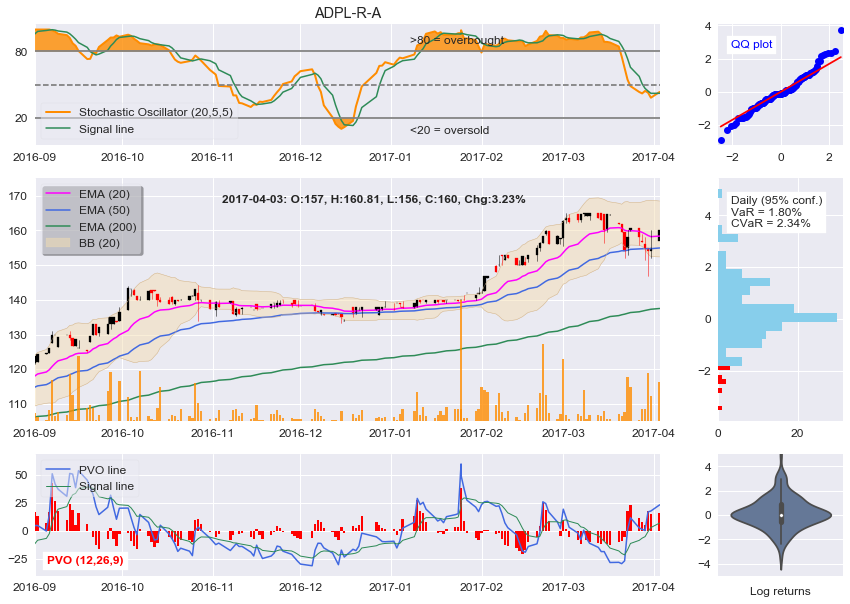

In [38]:
fig = plt.figure(figsize=(12,8.5))
gx = gs.GridSpec(nrows=3, ncols=2, height_ratios=[1,2,1], width_ratios=[5,1])
axt = fig.add_subplot(gx[0,0])
ax0 = fig.add_subplot(gx[1,0], sharex=axt)  # main 
axr = ax0.twinx()
ax1 = fig.add_subplot(gx[2,0], sharex=ax0)
axq = fig.add_subplot(gx[0,1])
axh = fig.add_subplot(gx[1,1])
axv = fig.add_subplot(gx[2,1])
# Top figure (left)
axt.set_title(stock_name)
axt.plot(quotes.index, osc_line, color='darkorange', lw=2, label='Stochastic Oscillator (20,5,5)')
axt.plot(quotes.index, osc_signal, color='seagreen', lw=1.5, label='Signal line')
axt.axhline(80, color='grey')
axt.axhline(50, color='grey', ls='--')
axt.axhline(20, color='grey')
axt.fill_between(quotes.index, osc_line, 80, where=(osc_line >= 80), 
                 interpolate=True, color='darkorange', alpha=0.8)
axt.fill_between(quotes.index, osc_line, 20, where=(osc_line <= 20), 
                 interpolate=True, color='darkorange', alpha=0.8)
axt.text(0.6, 0.9, '>80 = overbought', va='top', transform=axt.transAxes, fontsize=12)
axt.text(0.6, 0.1, '<20 = oversold', transform=axt.transAxes, fontsize=12)
#axt.set_ylim(0, 100)
axt.set_yticks([20, 80])
axt.legend(loc='lower left', frameon='fancy', fancybox=True, framealpha=0.5)
# Middle figure left
# Volume (mountain plot or bars plot)
vmax = quotes[u'Količina'].ix[date_start:date_end].max()
if len(quotes[u'Količina'].ix[date_start:date_end]) > 250:
    axr.fill_between(quotes.index, quotes[u'Količina'], 0, color='darkorange', alpha=0.8)
    axr.set_yticks([])
    axr.grid(False)
else:
    axr.bar(quotes.index, quotes[u'Količina'], width=0.8, color='darkorange', alpha=0.8)
    axr.set_yticks([])
    axr.grid(False)
axr.set_ylim(0, 2*vmax)
# EMA (20), EMA (50) and EMA (200)
ax0.plot(quotes.index, ema20, ls='-', lw=1.5, c='magenta', label='EMA (20)')
ax0.plot(quotes.index, ema50, ls='-', lw=1.5, c='royalblue', label='EMA (50)')
ax0.plot(quotes.index, ema200, ls='-', lw=1.5, c='seagreen', label='EMA (200)')
# Bollinger band (20)
ax0.fill_between(quotes.index, lowr, uppr, color='wheat', alpha=0.5, label='BB (20)')
ax0.plot(quotes.index, lowr, ls='-', lw=0.5, c='tan', label='')
ax0.plot(quotes.index, uppr, ls='-', lw=0.5, c='tan', label='')
# Candlestics
if len(quotes['Zadnja'].ix[date_start:date_end]) > 250:
    candle_width = 1
else:
    candle_width = 0.8  # default
candlestick_ohlc(ax0, qdata, width=candle_width)  # candlesticks
ax0.legend(loc='upper left', frameon='fancy', fancybox=True, shadow=True, framealpha=0.5)
# Print OHLC for the last trading day
last = quotes.iloc[-1]
s = '{:s}: O:{:g}, H:{:g}, L:{:g}, C:{:g}, \
Chg:{:g}%'.format(str(last.name)[:10], last['Prva'], last[u'Najviša'], last[u'Najniža'], 
                  last['Zadnja'], last['Promjena'])
ax0.text(0.3, 0.9, s, transform=ax0.transAxes, fontsize=12, fontweight='bold')
ymin = min(quotes[u'Najniža'].ix[date_start:date_end].min(), 
           lowr.ix[date_start:date_end].min(), 
           ema20.ix[date_start:date_end].min(), 
           ema50.ix[date_start:date_end].min(), 
           ema200.ix[date_start:date_end].min())
ymax = max(quotes[u'Najviša'].ix[date_start:date_end].max(), 
           uppr.ix[date_start:date_end].max(), 
           ema20.ix[date_start:date_end].max(), 
           ema50.ix[date_start:date_end].max(), 
           ema200.ix[date_start:date_end].max())
diff = (ymax - ymin)*0.05
ax0.set_ylim(myround(ymin-diff), myround(ymax+diff))
# Bottom figure (left)
# Percenage Volume Oscilator (PVO)
ax1.plot(quotes.index, pvo_line, ls='-', lw=1.5, c='royalblue', label='PVO line')
ax1.plot(quotes.index, pvo_signal_line, ls='-', lw=1, c='seagreen', label='Signal line')
if len(pvo_line.ix[date_start:date_end]) > 250:
    ax1.bar(quotes.index, pvo_hist, width=1, color='red')
else:
    ax1.bar(quotes.index, pvo_hist, width=0.8, color='red')
ymin_pvo = min(pvo_line.ix[date_start:date_end].min(),
               pvo_signal_line.ix[date_start:date_end].min(),
               pvo_hist.ix[date_start:date_end].min())
ymax_pvo = max(pvo_line.ix[date_start:date_end].max(),
               pvo_signal_line.ix[date_start:date_end].max(),
               pvo_hist.ix[date_start:date_end].max())
diff_pvo = (ymax_pvo - ymin_pvo)*0.1
ax1.set_ylim(int(ymin_pvo-diff_pvo), int(ymax_pvo+diff_pvo))
ax1.text(0.02, 0.1, 'PVO (12,26,9)', transform=ax1.transAxes, fontsize=12, 
         fontweight='bold', color='red', backgroundcolor='white')
ax1.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.5)
ax1.set_xlim(date_start, date_end)  # Clipping view
# Right column figures deal with simple log returns analysis
# Top right figure
ret_data = returns.values
#axq.set_title('Normality test', fontsize=12)
# Q-Q plot of simple log returns (Normality test)
sm.graphics.qqplot(ret_data, stats.norm, fit=True, line='q', ax=axq)
axq.text(0.1, 0.8, 'QQ plot', transform=axq.transAxes, fontsize=12, 
         color='blue', backgroundcolor='white')
axq.set_xlabel('')
axq.set_ylabel('')
# Middle right figure
#axh.set_title('Daily at 95%', fontsize=11)
lower_var = ret_data[ind]
upper_var = ret_data[~ind]
upper_var = upper_var[~np.isnan(upper_var)]
# Number of bins is fixed here, but can be determined using 
# any of the methods availabale in the numpy.hist function!
axh.hist(upper_var, bins=20, orientation='horizontal', color='skyblue', label='')
axh.hist(lower_var, bins=10, orientation='horizontal', color='red', label='')
axh.text(0.1, 0.8, 'Daily (95% conf.)\nVaR = {:.2f}%\nCVaR = {:.2f}%'.format(abs(VaR), abs(CVaR)), 
         transform=axh.transAxes, fontsize=12, backgroundcolor='white')
# Bottom right figure (violin plot)
sns.violinplot(ret_data, orient='v', saturation=0.5, ax=axv)
axv.set_ylim(-5, 5)
axv.set_xlabel('Log returns', fontsize=12)
plt.tight_layout()
plt.savefig(stock_name+'(2)'+'.png', dpi=600)
plt.show()

## Plot Variant C

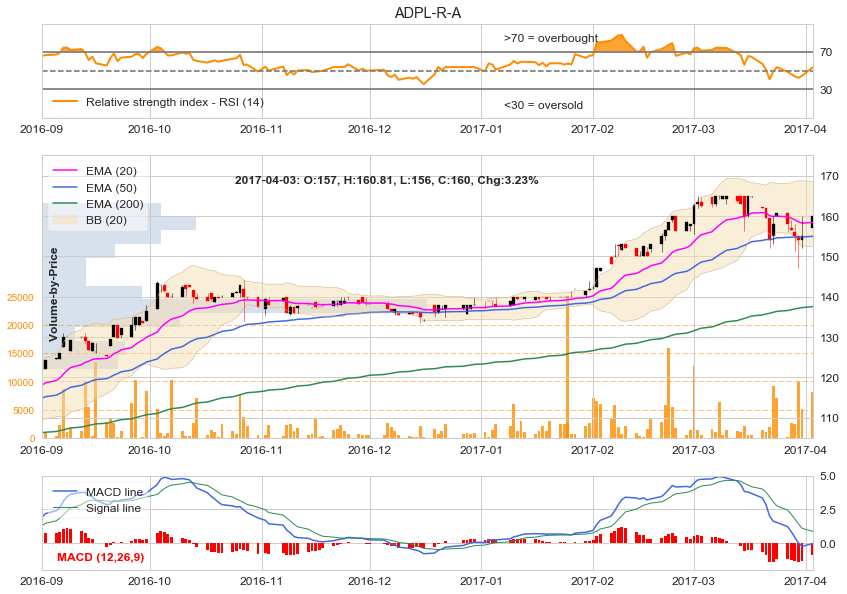

In [39]:
sns.set(context='notebook', style='whitegrid', font_scale=1.2)  # Change of style
fig = plt.figure(figsize=(12,8.5))
gx = gs.GridSpec(nrows=3, ncols=1, height_ratios=[1,3,1])
# Top figure axis
axt = fig.add_subplot(gx[0])
# Middle figure axis
ax0 = fig.add_subplot(gx[1], sharex=axt)
axr = ax0.twinx()   # Volume (mountain plot)
axz = ax0.twiny()   # Volume-by-Price indicator 
axz.set_xticks([])  # do not show top x-axis
# Format axis order
axz.set_zorder(1)
axr.set_zorder(2)
ax0.set_zorder(3) 
ax0.patch.set_visible(False)  # hide the 'canvas'
axr.patch.set_visible(False)
# Bottom figure axis
ax1 = fig.add_subplot(gx[2], sharex=ax0)
# Show y-axis tickmarks right
axt.yaxis.tick_right()
ax0.yaxis.tick_right()
ax1.yaxis.tick_right()
axr.yaxis.tick_left()
# Top figure
axt.set_title(stock_name)
axt.plot(quotes.index, rsi, ls='-', lw=2, color='darkorange', label='Relative strength index - RSI (14)')
axt.axhline(70, color='grey')
axt.axhline(50, color='grey', ls='--')
axt.axhline(30, color='grey')
axt.fill_between(quotes.index, rsi, 70, where=(rsi >= 70), interpolate=True, color='darkorange', alpha=0.8)
axt.fill_between(quotes.index, rsi, 30, where=(rsi <= 30), interpolate=True, color='darkorange', alpha=0.8)
axt.text(0.6, 0.9, '>70 = overbought', va='top', transform=axt.transAxes, fontsize=12)
axt.text(0.6, 0.1, '<30 = oversold', transform=axt.transAxes, fontsize=12)
axt.set_ylim(0, 100)
axt.set_yticks([30, 70])
axt.legend(loc='lower left')
# Middle figure
ymin = min(quotes[u'Najniža'].ix[date_start:date_end].min(), 
           lowr.ix[date_start:date_end].min(), 
           ema20.ix[date_start:date_end].min(), 
           ema50.ix[date_start:date_end].min(), 
           ema200.ix[date_start:date_end].min())
ymax = max(quotes[u'Najviša'].ix[date_start:date_end].max(), 
           uppr.ix[date_start:date_end].max(), 
           ema20.ix[date_start:date_end].max(), 
           ema50.ix[date_start:date_end].max(), 
           ema200.ix[date_start:date_end].max())
diff = (ymax - ymin)*0.05
# Volume-by-Price indicator
ax0.text(0.01, 0.65, 'Volume-by-Price', transform=ax0.transAxes, fontsize=12, 
         rotation=90, fontweight='bold')
#bars_height = ((ymax - ymin)/12)*0.85
bars_height = (prices.max() - prices.min())/12
axz.barh(zones[:-1], vol_by_price, height=bars_height, color='lightsteelblue', alpha=0.5)
axz.set_ylim(myround(ymin-diff), myround(ymax+diff))
axz.set_xlim(0, 2*vol_by_price.max())  # adjust bars
axz.grid(False)  # remove grid from this axis
# Volume (mountain plot or bars plot)
vmax = quotes[u'Količina'].ix[date_start:date_end].max()
if len(quotes[u'Količina'].ix[date_start:date_end]) > 250:
    axr.fill_between(quotes.index, quotes[u'Količina'], 0, color='darkorange', alpha=0.8)
    axr.set_yticks([])
    axr.grid(False)
else:
    axr.bar(quotes.index, quotes[u'Količina'], width=0.8, color='darkorange', alpha=0.8)
    axr.tick_params(axis='y', colors='darkorange', labelsize=10)
    axr.set_yticks([int(round(x)) for x in np.linspace(0, vmax, 6)])
    axr.grid(True, which='major', color='darkorange', linestyle='--', lw=0.5)
axr.set_ylim(0, 2*vmax)
# EMA (20), EMA (50) and EMA (200)
ax0.plot(quotes.index, ema20, ls='-', lw=1.5, c='magenta', label='EMA (20)')
ax0.plot(quotes.index, ema50, ls='-', lw=1.5, c='royalblue', label='EMA (50)')
ax0.plot(quotes.index, ema200, ls='-', lw=1.5, c='seagreen', label='EMA (200)')
# Bollinger band (20)
ax0.fill_between(quotes.index, lowr, uppr, color='wheat', alpha=0.5, label='BB (20)')
ax0.plot(quotes.index, lowr, ls='-', lw=0.5, c='tan', label='')
ax0.plot(quotes.index, uppr, ls='-', lw=0.5, c='tan', label='')
# Candlestics
if len(quotes['Zadnja'].ix[date_start:date_end]) > 250:
    candle_width = 1
else:
    candle_width = 0.8  # default
candlestick_ohlc(ax0, qdata, width=candle_width)  # candlesticks
ax0.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.5)
# Print OHLC for the last trading day
last = quotes.iloc[-1]
s = '{:s}: O:{:g}, H:{:g}, L:{:g}, C:{:g}, \
Chg:{:g}%'.format(str(last.name)[:10], last['Prva'], last[u'Najviša'], last[u'Najniža'], 
                  last['Zadnja'], last['Promjena'])
ax0.text(0.25, 0.9, s, transform=ax0.transAxes, fontsize=12, fontweight='bold')
ax0.set_ylim(myround(ymin-diff), myround(ymax+diff))  # set limits on y-axis
# Bottom figure
ax1.plot(quotes.index, macd_line, ls='-', lw=1.5, c='royalblue', label='MACD line')
ax1.plot(quotes.index, signal_line, ls='-', lw=1, c='seagreen', label='Signal line')
if len(macd_line.ix[date_start:date_end]) > 250:
    ax1.bar(quotes.index, macd_hist, width=1, color='red')
else:
    ax1.bar(quotes.index, macd_hist, width=0.8, color='red')
ymin_macd = min(macd_line.ix[date_start:date_end].min(),
                signal_line.ix[date_start:date_end].min(),
                macd_hist.ix[date_start:date_end].min())
ymax_macd = max(macd_line.ix[date_start:date_end].max(),
                signal_line.ix[date_start:date_end].max(),
                macd_hist.ix[date_start:date_end].max())
diff_macd = (ymax_macd - ymin_macd)*0.1
ax1.set_ylim(int(ymin_macd-diff_macd), int(ymax_macd+diff_macd))
ax1.text(0.02, 0.1, 'MACD (12,26,9)', transform=ax1.transAxes, fontsize=12, 
         fontweight='bold', color='red', backgroundcolor='white')
ax1.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.5)
ax1.set_xlim(date_start, date_end)  # Clipping view
plt.tight_layout()
plt.savefig(stock_name+'(3)'+'.png', dpi=600)
plt.show()

## Plot Variant D

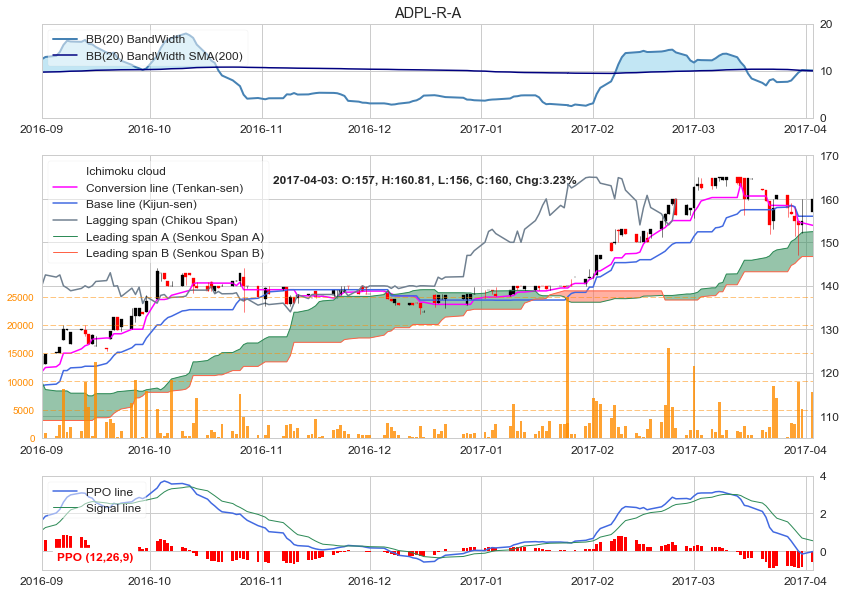

In [40]:
fig = plt.figure(figsize=(12,8.5))
gx = gs.GridSpec(nrows=3, ncols=1, height_ratios=[1,3,1])
axt = fig.add_subplot(gx[0])
ax0 = fig.add_subplot(gx[1], sharex=axt)
axr = ax0.twinx()
axr.set_yticks([])  # do not show right y-axis
ax1 = fig.add_subplot(gx[2], sharex=axt)
# Show y-axis tickmarks right
axt.yaxis.tick_right()
ax0.yaxis.tick_right()
ax1.yaxis.tick_right()
axr.yaxis.tick_left()
# Top figure
axt.set_title(stock_name)
# Bollinger band BB (20) BandWidth
axt.plot(quotes.index, bb_width, ls='-', lw=2, c='steelblue', label='BB(20) BandWidth')
axt.plot(quotes.index, bb_width_ma200, ls='-', lw=1.5, c='navy', label='BB(20) BandWidth SMA(200)')
axt.fill_between(quotes.index, bb_width, bb_width_ma200, where=bb_width>=bb_width_ma200, 
                 interpolate=True, color='skyblue', alpha=0.5, label='')
ymin_bb = min(bb_width.ix[date_start:date_end].min(),
              bb_width_ma200.ix[date_start:date_end].min())
ymax_bb = max(bb_width.ix[date_start:date_end].max(),
              bb_width_ma200.ix[date_start:date_end].max())
diff_bb = (ymax_bb - ymin_bb)*0.2
axt.set_ylim(int(ymin_bb-diff_bb), int(ymax_bb+diff_bb))
axt.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.5)
# Middle figure
# Volume (mountain plot or bars plot)
vmax = quotes[u'Količina'].ix[date_start:date_end].max()
if len(quotes[u'Količina'].ix[date_start:date_end]) > 250:
    axr.fill_between(quotes.index, quotes[u'Količina'], 0, color='darkorange', alpha=0.8)
    axr.set_yticks([])
    axr.grid(False)
else:
    axr.bar(quotes.index, quotes[u'Količina'], width=0.8, color='darkorange', alpha=0.8)
    axr.tick_params(axis='y', colors='darkorange', labelsize=10)
    axr.set_yticks([int(round(x)) for x in np.linspace(0, vmax, 6)])
    axr.grid(True, which='major', color='darkorange', linestyle='--', lw=0.5)
axr.set_ylim(0, 2*vmax)
# Ichimoku cloud
ax0.plot([0], [0], ls='', label='Ichimoku cloud')  # empty line for legend label
ax0.plot(quotes.index, conversion_line, ls='-', lw=1.5, c='magenta', label='Conversion line (Tenkan-sen)')
ax0.plot(quotes.index, base_line, ls='-', lw=1.5, c='royalblue', label='Base line (Kijun-sen)')
ax0.plot(quotes.index, lagging_span, ls='-', lw=1.5, c='slategrey', label='Lagging span (Chikou Span)')
ax0.fill_between(quotes.index, leading_span_B, leading_span_A, 
                 where=leading_span_A>=leading_span_B, color='seagreen', 
                 interpolate=True, alpha=0.5, label='')
ax0.fill_between(quotes.index, leading_span_B, leading_span_A, 
                 where=leading_span_B>leading_span_A, color='tomato', 
                 interpolate=True, alpha=0.5, label='')
ax0.plot(quotes.index, leading_span_A, ls='-', lw=1, c='seagreen', label='Leading span A (Senkou Span A)')
ax0.plot(quotes.index, leading_span_B, ls='-', lw=1, c='tomato', label='Leading span B (Senkou Span B)')
# Candlestics
if len(quotes['Zadnja'].ix[date_start:date_end]) > 250:
    candle_width = 1
else:
    candle_width = 0.8  # default
candlestick_ohlc(ax0, qdata, width=candle_width)  # candlesticks
ax0.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.5)
# Print OHLC for the last trading day
last = quotes.iloc[-1]
s = '{:s}: O:{:g}, H:{:g}, L:{:g}, C:{:g}, \
Chg:{:g}%'.format(str(last.name)[:10], last['Prva'], last[u'Najviša'], last[u'Najniža'], 
                  last['Zadnja'], last['Promjena'])
ax0.text(0.3, 0.9, s, transform=ax0.transAxes, fontsize=12, fontweight='bold')
ymin = min(quotes[u'Najniža'].ix[date_start:date_end].min(), 
           conversion_line.ix[date_start:date_end].min(), 
           base_line.ix[date_start:date_end].min(), 
           leading_span_A.ix[date_start:date_end].min(), 
           leading_span_B.ix[date_start:date_end].min())
ymax = max(quotes[u'Najviša'].ix[date_start:date_end].max(), 
           conversion_line.ix[date_start:date_end].max(), 
           base_line.ix[date_start:date_end].max(), 
           leading_span_A.ix[date_start:date_end].max(), 
           leading_span_B.ix[date_start:date_end].max())
diff = (ymax - ymin)*0.05
ax0.set_ylim(myround(ymin-diff), myround(ymax+diff))
# Bottom figure (Percenage Price Oscilator)
ax1.plot(quotes.index, ppo_line, ls='-', lw=1.5, c='royalblue', label='PPO line')
ax1.plot(quotes.index, ppo_signal_line, ls='-', lw=1, c='seagreen', label='Signal line')
if len(ppo_line.ix[date_start:date_end]) > 250:
    ax1.bar(quotes.index, ppo_hist, width=1, color='red')
else:
    ax1.bar(quotes.index, ppo_hist, width=0.8, color='red')
ymin_ppo = min(ppo_line.ix[date_start:date_end].min(),
               ppo_signal_line.ix[date_start:date_end].min(),
               ppo_hist.ix[date_start:date_end].min())
ymax_ppo = max(ppo_line.ix[date_start:date_end].max(),
               ppo_signal_line.ix[date_start:date_end].max(),
               ppo_hist.ix[date_start:date_end].max())
diff_ppo = (ymax_ppo - ymin_ppo)*0.2
ax1.set_ylim(int(ymin_ppo-diff_ppo), int(ymax_ppo+diff_ppo))
ax1.text(0.02, 0.1, 'PPO (12,26,9)', transform=ax1.transAxes, fontsize=12, 
         fontweight='bold', color='red', backgroundcolor='white')
ax1.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.5)
ax1.set_xlim(date_start, date_end)  # Clipping view
plt.tight_layout()
plt.savefig(stock_name+'(4)'+'.png', dpi=600)
plt.show()

## CROBEX Index

In [41]:
# Povijesni podaci CROBEX indexa sa Zagrebačke burze (www.zse.hr)
# Historical CROBEX index data from the Zagreb Stock Exchange (www.zse.hr)
crobex = pd.read_excel('zse_export_CROBEX.xlsx')
crobex = crobex.set_index(pd.DatetimeIndex(crobex['Datum']))

In [42]:
del crobex['Datum']
# Reverse order
crobex = crobex.ix[::-1]

In [43]:
crobex.tail()

,Prva,Najviša,Najniža,Zadnja,Promjena,Promet dionica u sastavu indeksa
Datum,,,,,,
2017-03-20,2177.22,2182.51,2153.30,2154.34,-1.05,10508915.67
2017-03-21,2156.29,2156.93,2129.16,2132.91,-0.99,12090512.28
2017-03-22,2134.52,2135.29,2079.04,2081.26,-2.42,15530447.25
2017-03-23,2079.51,2079.51,2045.18,2065.15,-0.77,13511381.79
2017-03-24,2068.49,2117.24,2065.78,2112.83,2.31,9191258.11


In [44]:
del crobex['Promet dionica u sastavu indeksa']
del quotes['log_returns']

In [ ]:
# WARNING: We can "forward fill" missing days (weekend and non-trading days)
#          but this will create more (redundant) data for subsequent figures
#crobex = crobex.resample('D').mean()
#crobex = crobex.ffill()
#crobex.head(10)

In [45]:
# Web scraping ZSE website for CROBEX index data
# http://zse.hr/default.aspx?id=44101&index=CROBEX
address = 'http://zse.hr/default.aspx?id=44101&index=CROBEX'
page = urllib2.urlopen(address)
soup = bs4.BeautifulSoup(page, 'lxml')

In [46]:
# Extract table from web page
table = soup.find_all('table', class_='dnevna_trgovanja sorttable')
# There are two tables in the webpage, we need second one: table[1]
# Extract all rows from the table
rows = table[1].findAll('tr')
data = []; sdata = []
for row in rows[1:]:
    # Extract cells from each row
    cells = row.findAll('td')
    for elem in cells:
        # Extract text strings from cells
        data.append(elem.find(text=True))
clean_data = []
for s in data:
    # Remove non-printing characters from strings
    clean_data.append(re.sub('[^\040-\176]', '', s))

In [47]:
datum = []
prva = []
najvisa = []
najniza = []
zadnja = []
promjena = []
promet = []
for i in range(0, len(clean_data), 7):
    datum.append(clean_data[i])
    prva.append(replace_convert(clean_data[i+1]))
    najvisa.append(replace_convert(clean_data[i+2]))
    najniza.append(replace_convert(clean_data[i+3]))
    zadnja.append(replace_convert(clean_data[i+4]))
    promjena.append(replace_convert(clean_data[i+5]))
    promet.append(replace_convert(clean_data[i+6]))

In [48]:
column_names = ['Prva', 'Zadnja', u'Najviša', u'Najniža', 'Promjena', 'Promet']
podaci = pd.DataFrame(data={'Prva':prva, u'Najviša':najvisa, u'Najniža':najniza,
                            'Zadnja':zadnja, 'Promjena':promjena, 'Promet':promet},
                      index=pd.to_datetime(datum, dayfirst=True), columns=column_names)

In [49]:
del podaci['Promet']
# Reverse order
podaci = podaci.iloc[::-1]

In [50]:
# Adding new rows to the existing DataFrame
data_all = pd.concat([crobex, podaci])
# Remove duplicate dates
data_all = data_all.drop_duplicates(keep='last').copy()

In [51]:
# Join the stock data with CROBEX index data to form a new dataframe
df = data_all.join(quotes, lsuffix='_c').ffill()
df.tail()

,Najniža_c,Najviša_c,Promjena_c,Prva_c,Zadnja_c,Prva,Zadnja,Najviša,Najniža,Prosječna,Promjena,Količina,Promet
2017-03-28,2071.78,2100.86,-0.94,2096.08,2077.12,157.00,156.54,159.00,156.54,157.13,-0.92,2623.0,412164.22
2017-03-29,1988.07,2074.71,-2.98,2074.38,2015.12,156.00,155.00,158.00,151.36,154.36,-0.98,2531.0,390675.62
2017-03-30,1914.46,2012.53,-3.06,2010.70,1953.39,154.99,154.00,155.00,147.00,151.02,-0.65,9949.0,1502503.83
2017-03-31,1936.57,1995.74,1.84,1949.19,1989.27,154.00,155.00,160.00,152.07,156.89,0.65,5124.0,803885.64
2017-04-03,1990.10,2042.63,2.31,1990.10,2035.31,157.00,160.00,160.81,156.00,159.42,3.23,8103.0,1291757.41


In [52]:
# Simple returns
simreturns = df['Zadnja'].ix[date_start:date_end].pct_change()
# Cumulative simple returns
cumsimrets = ((1 + simreturns).cumprod() - 1)*100.

In [53]:
# CROBEX returns
crobex_simreturns = df['Zadnja_c'].ix[date_start:date_end].pct_change()
crobex_cumsimrets = ((1 + crobex_simreturns).cumprod() - 1)*100.

In [54]:
# CROBEX Index SMA (20)
crobex_sma20 = crobex_cumsimrets.rolling(window=20).mean()
# Cumulative simple returns SMA (20)
cumsimrets_sma20 = cumsimrets.rolling(window=20).mean()

In [55]:
# Correlation coefficient
# http://www.stockcharts.com/school/doku.php?id=chart_school:
#technical_indicators:correlation_coeffici
# Correlation coefficient between Stock price and CROBEX index
corr_coef = df['Zadnja_c'].rolling(window=20).corr(df['Zadnja'])
corr_coef_sma50 = corr_coef.rolling(window=50).mean()

In [56]:
# Bollinger bands on Cumulative Simple returns
cumsimrets_sda20 = cumsimrets.rolling(window=20).std()
cumsimrets_lowr = cumsimrets_sma20 - 2.*cumsimrets_sda20
cumsimrets_uppr = cumsimrets_sma20 + 2.*cumsimrets_sda20
# Bollinger Bands on CROBIS index
crobex_sda20 = crobex_cumsimrets.rolling(window=20).std()
crobex_lowr = crobex_sma20 - 2.*crobex_sda20
crobex_uppr = crobex_sma20 + 2.*crobex_sda20

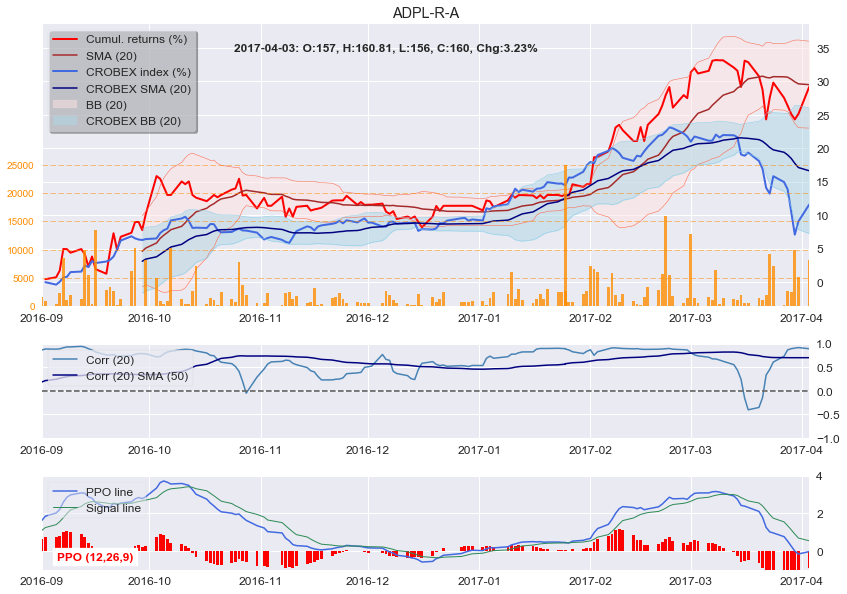

In [57]:
sns.set(context='notebook', style='darkgrid', font_scale=1.2)  # Change of style
fig = plt.figure(figsize=(12,8.5))
gx = gs.GridSpec(nrows=3, ncols=1, height_ratios=[3,1,1])
axt = fig.add_subplot(gx[0])
ax1 = fig.add_subplot(gx[1], sharex=axt)
axr = axt.twinx()
axr.set_yticks([])  # do not show right y-axis
ax2 = fig.add_subplot(gx[2], sharex=axt)
# Show y-axis tickmarks right
axt.yaxis.tick_right()
ax1.yaxis.tick_right()
ax2.yaxis.tick_right()
axr.yaxis.tick_left()
# Top figure
axt.set_title(stock_name)
# Cumulative Simple Returns
axt.plot(cumsimrets.index, cumsimrets, ls='-', lw=2, c='red', label='Cumul. returns (%)')
axt.plot(cumsimrets_sma20.index, cumsimrets_sma20, c='brown', ls='-', lw=1.5, label='SMA (20)')
# Bollinger band (20) on cumulative returns
axt.fill_between(cumsimrets_sma20.index, cumsimrets_lowr, cumsimrets_uppr, 
                 color='mistyrose', alpha=0.5, label='BB (20)')
axt.plot(cumsimrets_sma20.index, cumsimrets_lowr, ls='-', lw=0.5, c='tomato', label='')
axt.plot(cumsimrets_sma20.index, cumsimrets_uppr, ls='-', lw=0.5, c='tomato', label='')
# CROBEX index
axt.plot(crobex_cumsimrets.index, crobex_cumsimrets, ls='-', lw=2, c='royalblue', label='CROBEX index (%)')
axt.fill_between(crobex_sma20.index, crobex_lowr, crobex_uppr,
                 color='lightblue', alpha=0.5, label='CROBEX BB (20)')
axt.plot(crobex_sma20.index, crobex_lowr, c='skyblue', ls='-', lw=0.5, label='')
axt.plot(crobex_sma20.index, crobex_uppr, c='skyblue', ls='-', lw=0.5, label='')
axt.plot(crobex_sma20.index, crobex_sma20, c='navy', ls='-', lw=1.5, label='CROBEX SMA (20)')
axt.legend(loc='upper left', frameon='fancy', shadow=True, fancybox=True, framealpha=0.5)
# Print OHLC for the last trading day
last = quotes.iloc[-1]
s = '{:s}: O:{:g}, H:{:g}, L:{:g}, C:{:g}, \
Chg:{:g}%'.format(str(last.name)[:10], last['Prva'], last[u'Najviša'], last[u'Najniža'], 
                  last['Zadnja'], last['Promjena'])
axt.text(0.25, 0.9, s, transform=axt.transAxes, fontsize=12, fontweight='bold')
#axt.xaxis.set_major_formatter(DateFormatter('%b %Y'))  # Month names format
axt.set_xlim(date_start, date_end)  # Clipping view
# Volume (mountain plot or bars plot)
vmax = quotes[u'Količina'].ix[date_start:date_end].max()
if len(quotes[u'Količina'].ix[date_start:date_end]) > 250:
    axr.fill_between(quotes.index, quotes[u'Količina'], 0, color='darkorange', alpha=0.8)
    axr.set_yticks([])
    axr.grid(False)
else:
    axr.bar(quotes.index, quotes[u'Količina'], width=0.8, color='darkorange', alpha=0.8)
    axr.tick_params(axis='y', colors='darkorange', labelsize=10)
    axr.set_yticks([int(round(x)) for x in np.linspace(0, vmax, 6)])
    axr.grid(True, which='major', color='darkorange', linestyle='--', lw=0.5)
axr.set_ylim(0, 2*vmax)
# Correlation plot
ax1.plot(corr_coef.index, corr_coef, color='steelblue', ls='-', lw=1.5, label='Corr (20)')
ax1.plot(corr_coef_sma50.index, corr_coef_sma50, color='navy', ls='-', lw=1.5, label='Corr (20) SMA (50)')
ax1.axhline(0, color='dimgrey', ls='--')
ax1.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.75)
ax1.set_yticks([-1, -0.5, 0, 0.5, 1])
ax1.set_ylim(-1, 1)
# Bottom figure (Percenage Price Oscilator)
ax2.plot(quotes.index, ppo_line, ls='-', lw=1.5, c='royalblue', label='PPO line')
ax2.plot(quotes.index, ppo_signal_line, ls='-', lw=1, c='seagreen', label='Signal line')
if len(macd_line.ix[date_start:date_end]) > 250:
    ax2.bar(quotes.index, macd_hist, width=1, color='red')
else:
    ax2.bar(quotes.index, macd_hist, width=0.8, color='red')
ymin_ppo = min(ppo_line.ix[date_start:date_end].min(),
               ppo_signal_line.ix[date_start:date_end].min(),
               ppo_hist.ix[date_start:date_end].min())
ymax_ppo = max(ppo_line.ix[date_start:date_end].max(),
               ppo_signal_line.ix[date_start:date_end].max(),
               ppo_hist.ix[date_start:date_end].max())
diff_ppo = (ymax_ppo - ymin_ppo)*0.2
ax2.set_ylim(int(ymin_ppo-diff_ppo), int(ymax_ppo+diff_ppo))
ax2.text(0.02, 0.1, 'PPO (12,26,9)', transform=ax2.transAxes, fontsize=12, 
         fontweight='bold', color='red', backgroundcolor='white')
ax2.legend(loc='upper left', frameon='fancy', fancybox=True, framealpha=0.5)
plt.tight_layout()
plt.savefig(stock_name+'(CROBEX)'+'.png', dpi=600)
plt.show()